In [5]:
import sqlite3
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from category_encoders import OrdinalEncoder
from IPython.display import VimeoVideo
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils.validation import check_is_fitted
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

warnings.simplefilter(action="ignore", category=FutureWarning)

# Prepare Data

## Import

In [2]:
def wrangle(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
        SELECT distinct(i.building_id) AS b_id,
           s.*,
           d.damage_grade
        FROM id_map AS i
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 36
    """

    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col="b_id")

    # Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]

    # Add high-cardinality / redundant column
    drop_cols.append("building_id")

    # Create binary target column
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)

    # Drop old target
    drop_cols.append("damage_grade")

    # Drop multicollinearity column
    drop_cols.append("count_floors_pre_eq")

    # Drop columns
    df.drop(columns=drop_cols, inplace=True)

    return df

In [3]:
df = wrangle('/home/jumaa/PROJECT/Python/040earthquake_in_nepal/eq_nepal.sqlite')
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,supersructure,severe_damage
b_id,,,,,,,,,,,,
3.602060e+11,50,600,19,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Brick/Stone,Timber-Planck,Not attached,Rectangular,mud_mortar_stone,1
3.602060e+11,60,450,19,Moderate slope,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Brick/Stone,Timber-Planck,Not attached,Rectangular,mud_mortar_stone,1
3.602060e+11,13,522,19,Moderate slope,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Brick/Stone,Timber-Planck,Not attached,Rectangular,mud_mortar_stone,1
3.602060e+11,2,630,19,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Brick/Stone,Timber-Planck,Attached-1 side,Rectangular,mud_mortar_stone,1
3.602060e+11,50,588,19,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Brick/Stone,Timber-Planck,Not attached,Rectangular,mud_mortar_stone,1


## Explore

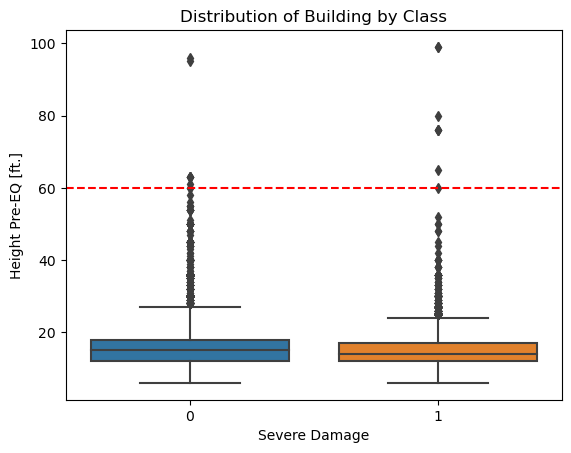

In [7]:
# Create boxplot
sns.boxplot(x=df['severe_damage'] , y=df['height_ft_pre_eq'])
plt.axhline(60 , linestyle='--' , color='r' )
# Label axes
plt.xlabel('Severe Damage')
plt.ylabel('Height Pre-EQ [ft.]')
plt.title('Distribution of Building by Class');

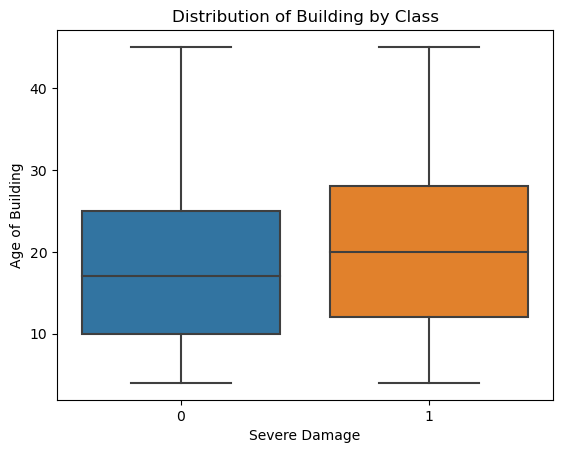

In [8]:
q1 , q9 = df['age_building'].quantile([0.1,0.9])
mask = df['age_building'].between(q1 , q9)
# Create boxplot
sns.boxplot(x=df['severe_damage'] , y=df[mask]['age_building'])
#plt.axhline(60 , linestyle='--' , color='r' )
# Label axes
plt.xlabel('Severe Damage')
plt.ylabel('Age of Building')
plt.title('Distribution of Building by Class');

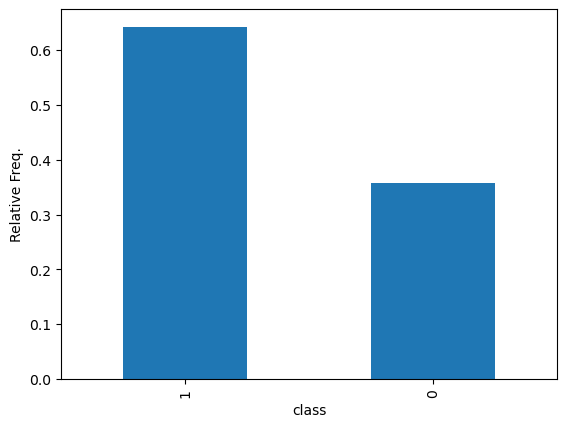

In [9]:
df["severe_damage"].value_counts(normalize=True).plot(kind="bar" , xlabel='class' , ylabel='Relative Freq.');
    

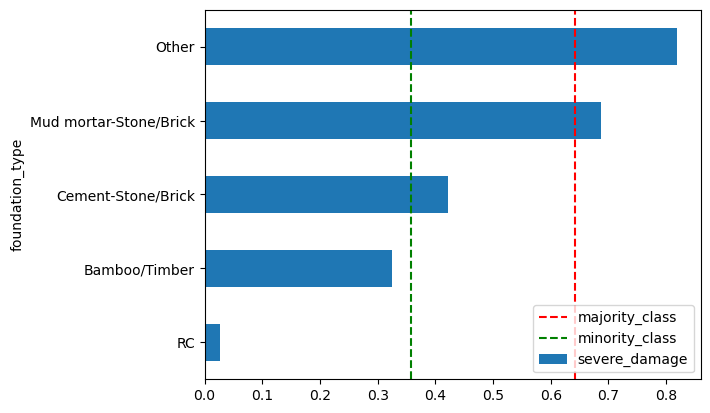

In [10]:
foundation_pivot = pd.pivot_table(
    df, index="foundation_type", values="severe_damage", aggfunc="mean"
).sort_values("severe_damage")

foundation_pivot.plot(kind="barh" )
plt.axvline(df["severe_damage"].value_counts(normalize=True).max() , linestyle='--' , color='r' , label='majority_class')
plt.axvline(df["severe_damage"].value_counts(normalize=True).min() , linestyle='--', color='g' , label='minority_class')
plt.legend(loc='lower right');

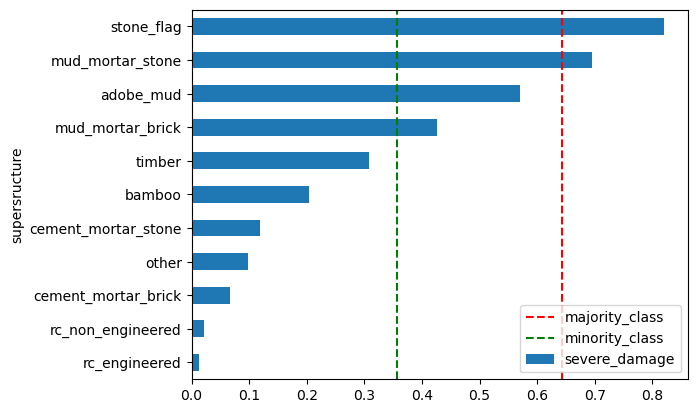

In [12]:
superstructure_pivot = pd.pivot_table(
    df, index="supersructure", values="severe_damage", aggfunc="mean"
).sort_values("severe_damage")

superstructure_pivot.plot(kind="barh" )
plt.axvline(df["severe_damage"].value_counts(normalize=True).max() , linestyle='--' , color='r' , label='majority_class')
plt.axvline(df["severe_damage"].value_counts(normalize=True).min() , linestyle='--', color='g' , label='minority_class')
plt.legend(loc='lower right');

## Split

In [13]:
target = "severe_damage"
X = df.drop(columns=target)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (70836, 11)
y shape: (70836,)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X , y , test_size=0.2 , random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (56668, 11)
y_train shape: (56668,)
X_test shape: (14168, 11)
y_test shape: (14168,)


# Build Model

## Baseline

In [15]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.64


# Iterate

So far, we've built single models that predict a single outcome. That's definitely a useful way to predict the future, but what if the one model we built isn't the *right* one? If we could somehow use more than one model simultaneously, we'd have a more trustworthy prediction.

**Ensemble models** work by building multiple models on random subsets of the same data, and then comparing their predictions to make a final prediction. Since we used a decision tree in the last lesson, we're going to create an ensemble of trees here. This type of model is called a **random forest**.

We'll start by creating a pipeline to streamline our workflow.

In [16]:
clf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42)
)
print(clf)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])


In [17]:
params = {
    "simpleimputer__strategy": ["mean" , "median"],
    "randomforestclassifier__n_estimators": range(25,75,25),
    "randomforestclassifier__max_depth": range(5,25,5)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'randomforestclassifier__n_estimators': range(25, 75, 25),
 'randomforestclassifier__max_depth': range(5, 25, 5)}

In [18]:
model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(5, 25, 5),
                         'randomforestclassifier__n_estimators': range(25, 75, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [19]:
# Train model
model.fit(X_train , y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(5, 25, 5),
                         'randomforestclassifier__n_estimators': range(25, 75, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [20]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 16 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   mean_fit_time                               16 non-null     float64
 1   std_fit_time                                16 non-null     float64
 2   mean_score_time                             16 non-null     float64
 3   std_score_time                              16 non-null     float64
 4   param_randomforestclassifier__max_depth     16 non-null     object 
 5   param_randomforestclassifier__n_estimators  16 non-null     object 
 6   param_simpleimputer__strategy               16 non-null     object 
 7   params                                      16 non-null     object 
 8   split0_test_score                           16 non-null     float64
 9   split1_test_score                           16 non-null     float64
 10  split2_test_scor

In [21]:
cv_results.sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,8.219260,0.418085,0.402237,0.145347,15,50,mean,"{'randomforestclassifier__max_depth': 15, 'ran...",0.724810,0.720222,0.723840,0.724168,0.730080,0.724624,0.003162,1
11,7.223429,0.752322,0.358340,0.046665,15,50,median,"{'randomforestclassifier__max_depth': 15, 'ran...",0.724810,0.720222,0.723840,0.724168,0.730080,0.724624,0.003162,1
14,7.398302,0.305328,0.506209,0.169780,20,50,mean,"{'randomforestclassifier__max_depth': 20, 'ran...",0.725163,0.721105,0.719958,0.723727,0.727698,0.723530,0.002783,3
15,5.778947,1.454639,0.304545,0.097083,20,50,median,"{'randomforestclassifier__max_depth': 20, 'ran...",0.725163,0.721105,0.719958,0.723727,0.727698,0.723530,0.002783,3
8,5.036733,0.607312,0.302830,0.062083,15,25,mean,"{'randomforestclassifier__max_depth': 15, 'ran...",0.722340,0.719340,0.723399,0.723198,0.728668,0.723389,0.003013,5


In [22]:
# Extract best hyperparameters
model.best_params_

{'randomforestclassifier__max_depth': 15,
 'randomforestclassifier__n_estimators': 50,
 'simpleimputer__strategy': 'mean'}

In [23]:
acc_train = model.score(X_train , y_train)
acc_test = model.score(X_test , y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 0.7671
Test Accuracy: 0.7307


In [24]:
y_test.value_counts()

1    9167
0    5001
Name: severe_damage, dtype: int64

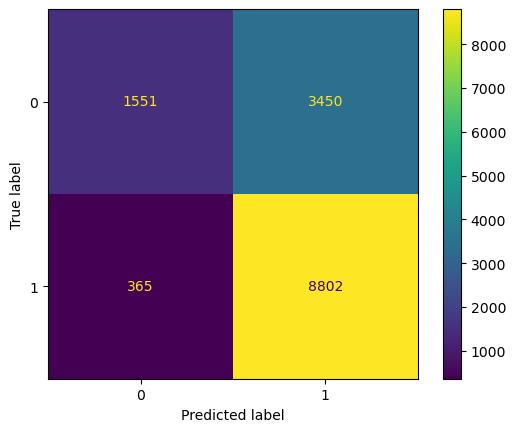

In [25]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model , X_test , y_test);

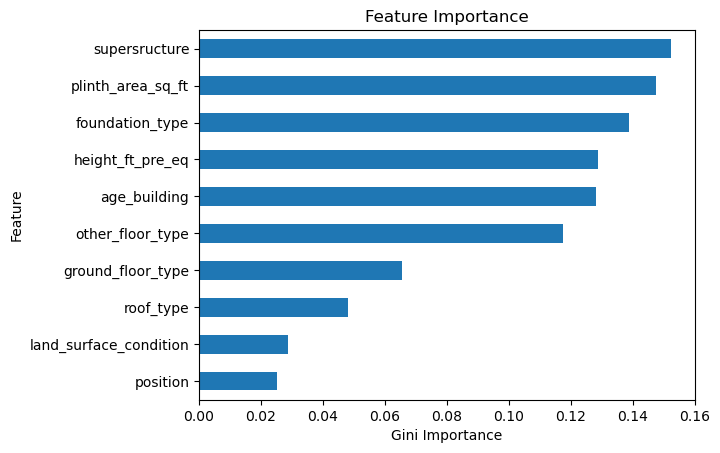

In [26]:
# Get feature names from training data
features = X_train.columns
# Extract importances from model
importances = model.best_estimator_.named_steps["randomforestclassifier"].feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances , index=features).sort_values()
# Plot 10 most important features
feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

In [27]:
def make_predictions(data_filepath, model_filepath):
    # Wrangle JSON file
    X_test = wrangle(data_filepath)
    # Load model
    with open(model_filepath , "rb") as f:
        model = pickle.load(f)
    # Generate predictions
    y_test_pred = model.predict(X_test)
    # Put predictions into Series with name "bankrupt", and same index as X_test
    y_test_pred = pd.Series(y_test_pred , index=X_test.index , name="bankrupt")
    return y_test_pred